<a href="https://colab.research.google.com/github/knolasco/League-of-Legends-Match-Predictions/blob/main/League_of_Legends_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this dataset was found in kaggle using the following link. The data was uploaded to github
#https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

# Introduction

League of Legends (LoL) is a competitive, online-multiplayer video game created by Riot Games in 2009. Two teams composed of five champions (these are the avatars of the game) each are placed on Summoner's Rift and are tasked with destroying the enemy team's nexus. Along the way, each summoner (player in control of the champion) can collect gold and gain experience by destroying towers or killing enemy champions or minions. The first team to destroy a nexus wins.

# Data

This project uses 10-minutes of data collected from over nine-thousand unique games. The games are all ranked games at high elo (Diamond 1 to Masters).

This dataset contains 40 columns including the "gameId" column which is a unique identifier. The target column is called "blueWins". The blue team wins the gain if "blueWins" is 1, otherwise the red team wins.

The remaining 38 columns are split into 19 columns describing the characteristics of the game for each team. Among these 38 columns are: "blueWardsDestroyed", "redWardsPlaced", "blueAvgLevel", and "redTowersDestroyed".

# Purpose

The purpose of this project is to build an accurate machine learning model that can determine whether a team will win a game based on the first 10 minutes of the game. From this insight, we can then look at the characteristics of the winning team.

It is important to note that this model cannot be 100% accurate because there is a lot that happens after the first 10 minutes of the game that can quickly change the tides of the game.

# Analysis

Now we take a look at our dataset, we begin by importing all the neccesary modules.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from xgboost import XGBClassifier

from scipy.stats import skew
from scipy.stats import randint, truncnorm, uniform

import warnings
warnings.filterwarnings('ignore')

Next we import the data and have a quick view at the first 5 elements.

In [3]:
data = pd.read_csv('https://github.com/knolasco/League-of-Legends-Match-Predictions/blob/main/high_diamond_ranked_10min.csv?raw=true')
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


We can also see a summary of the data as follows.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

It seems like there are no missing values, but we run the following line to be sure.

In [5]:
data.isna().values.any()

False

We have no missing values! Next we get a quick visualization of the data using histograms.

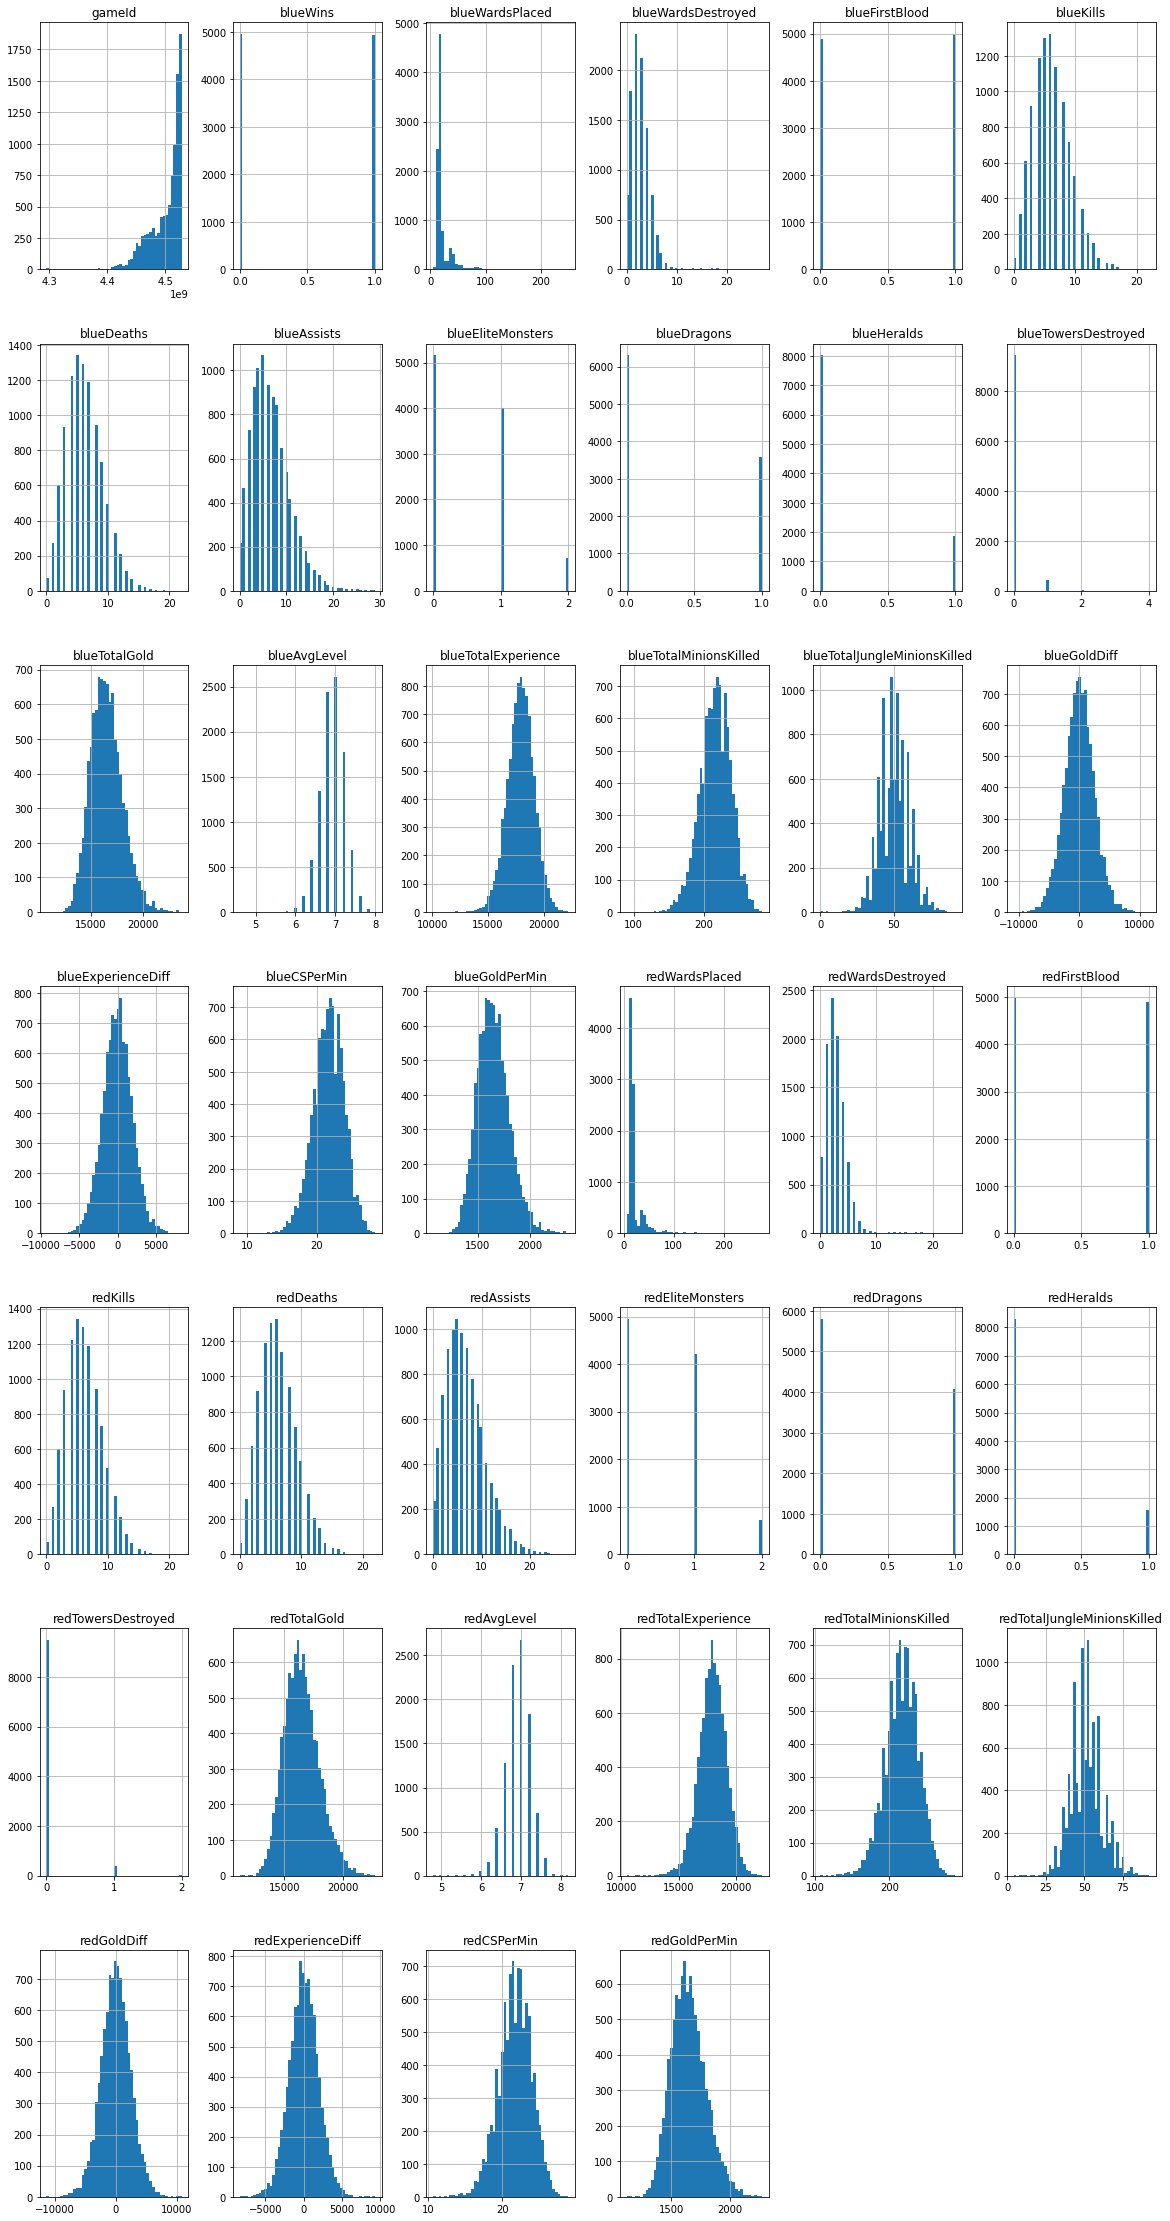

In [6]:
data.hist(bins = 50, figsize = (20,40))
plt.show()

It appears that most of the data is normally distributed!

## Baseline Model

Now I want to create a baseline model and the goal will be to pass the baseline's accuracy. The baseline model will use LogisticRegression.

First, we need to split the data into test/train sets and remove the target columns. We will train 80% of the data.

In [7]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 2)

# I will create a small function that separates the target variable

def get_target(data_set):
    return data_set.drop('blueWins', axis = 1), data_set['blueWins']

X_train, y_train = get_target(train_set)
X_test, y_test = get_target(test_set)

In [8]:
L_reg = LogisticRegression()
X_train_copy = X_train.copy() # I want to avoid changing the original
scores = cross_val_score(L_reg, X_train_copy, y_train, scoring = 'accuracy', cv = 10)

print(scores.mean())

0.5013285538254733


Looks like the baseline model has an accuracy of 50%. This is not the best model, but that is okay. Now the goal is to pass 50%.

# Feature Engineering

Now I would like to try some feature engineering. This will include adding new features, fixing skew, scaling the data and removing highly-correlated features.

### Creating new Features

We begin by adding new features. In the dataset, there are four attributes that relate to vision "(blue/red)WardsPlaced" and "(blue/red)WardsDestroyed". I will create a new feature "(blue/red)VisionScore", which demonstrates vision dominance. A team has better vision when they place their own wards and destroy enemy wards.

In [9]:
def add_attributes(X):
    X['blueVisionScore'] = X['blueWardsPlaced'] + X['redWardsDestroyed']
    X['redVisionScore'] = X['redWardsPlaced'] + X['blueWardsDestroyed']
    return X

X_train_copy = X_train.copy()
X_train_tr = add_attributes(X_train_copy)
print(X_train_tr.columns)

Index(['gameId', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin', 'blueVisionScore',
       'redVisionScore'],
      dtype='object')


The goal is to place this function into a pipeline, so I will create a class that has fit and transform methods.

In [10]:
class attributes_adder(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        return add_attributes(X)

### Fixing High Skew

Now we will create a function that finds the skew. By looking at the histograms above, we can see that some of the data is not normal. So I will exclude that when calculating the skew. We will attempt to fix the skew if the absolute value of the skew is greater than 0.5.

In [11]:
def intersection(x,y):
    return [val for val in x if val in y]

def find_high_skew(X):
    non_norm = ['gameId','blueFirstBlood','blueEliteMonsters','blueHeralds','blueDragons','blueTowersDestroyed',
              'redFirstBlood','redEliteMonsters','redHeralds','redDragons','redTowersDestroyed']
    non_norm = intersection(list(X.columns), non_norm)
    temp = X.drop(non_norm, axis = 1)
    cols = []
    skews = []
    for col in temp.columns:
        if abs(skew(temp[col])) > 0.5: # we will transform the attributes with high skew
            cols.append(col)
            skews.append(skew(temp[col]))
    return cols, skews

Columns with skew > 0.5


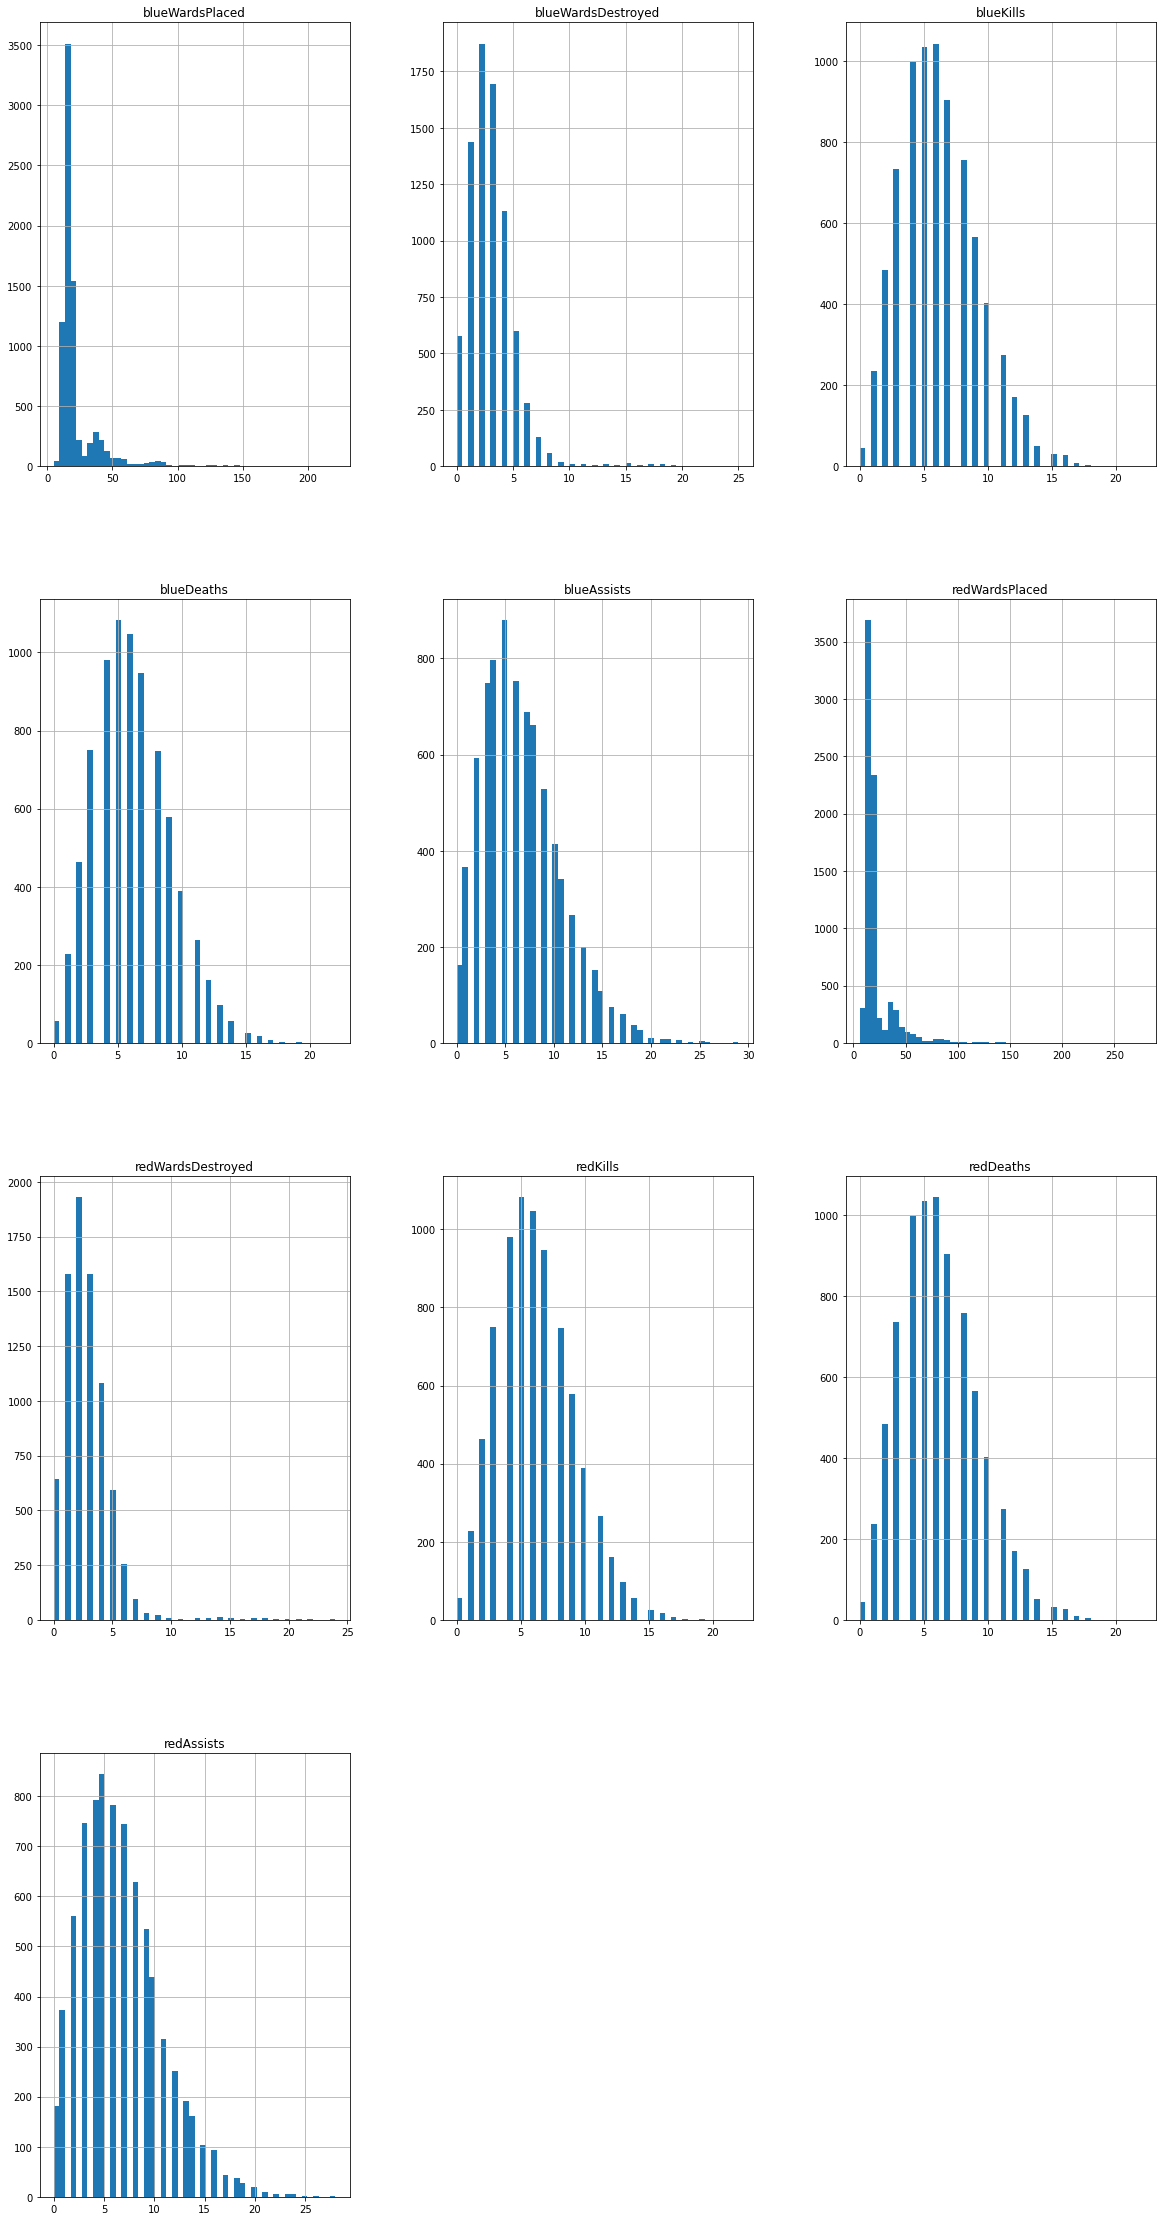

In [12]:
X_train_copy = X_train.copy()

cols, skews = find_high_skew(X_train_copy)

print("Columns with skew > 0.5")
    
X_train_copy[cols].hist(bins = 50, figsize = (20,40))
plt.show()

Just as before, I will create a custom class for this skew function that will later be put into a pipeline.

To fix the skew, we will attempt a square-root or log transformation.

Histograms after fixing the skew using a Log transformation.


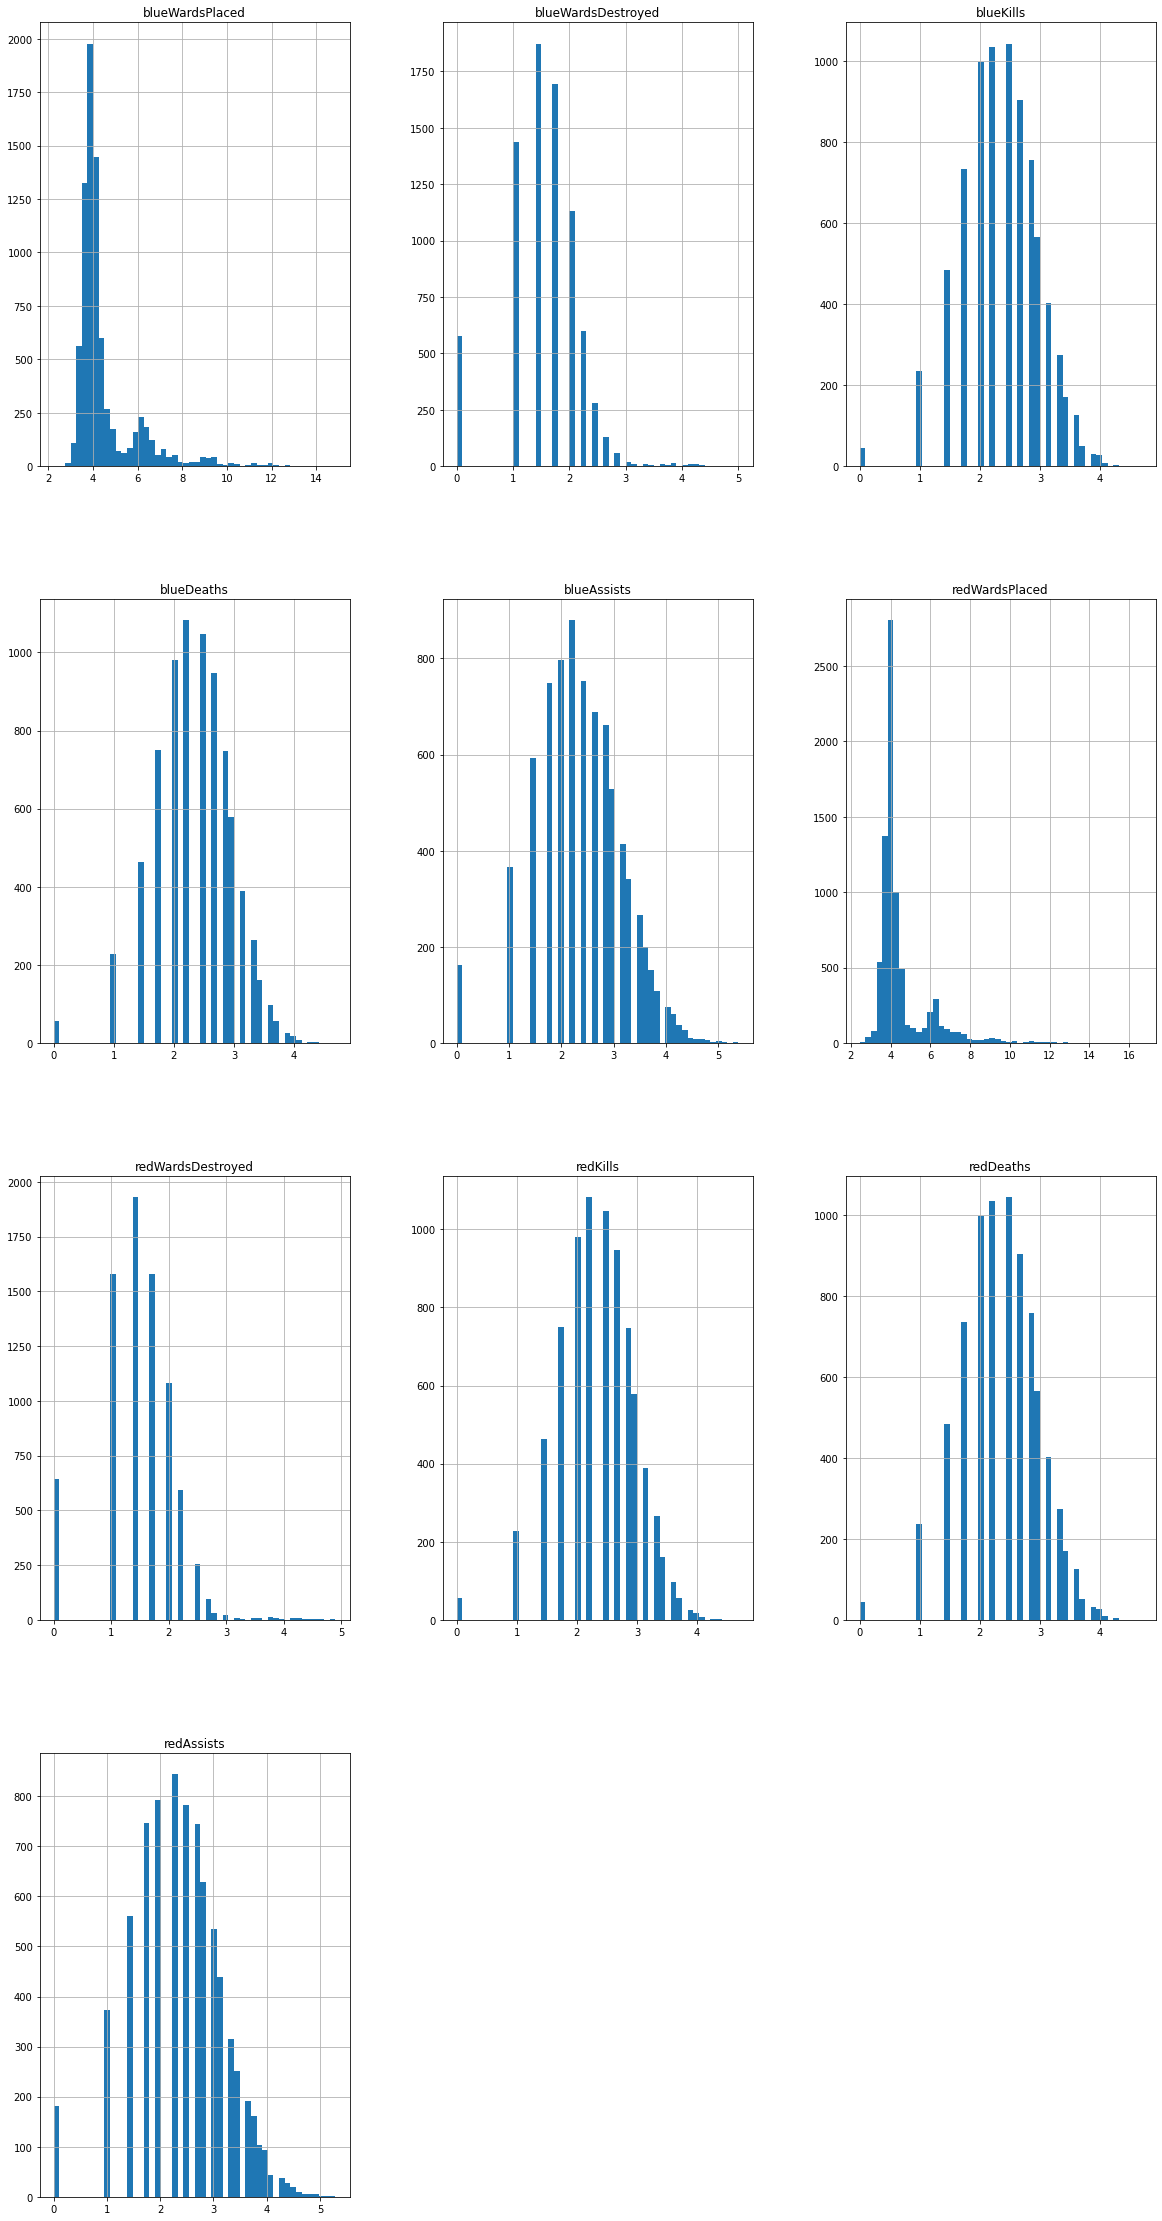

In [13]:
class fix_skew(BaseEstimator, TransformerMixin):
    def __init__(self, try_sqrt = True):
        self.try_sqrt = try_sqrt
    def fit(self,X):
        return self
    def transform(self,X):
        skewed_cols, _ = find_high_skew(X)
        if self.try_sqrt:
            for col in skewed_cols:
                X[col] = np.sqrt(X[col]) # try the square root tranformation
        else:
            for col in skewed_cols:
                X[col] = np.log(1 + X[col]) # otherwise, try a log tranformation
        return X

# now we test
testClass = fix_skew() # log transformation
X_train_copy = X_train.copy()
X_train_log = testClass.transform(X_train_copy)

print("Histograms after fixing the skew using a Log transformation.")
X_train_log[cols].hist(bins = 50, figsize = (20,40))
plt.show()

Histograms after fixing the skew using a Square Root transformation.


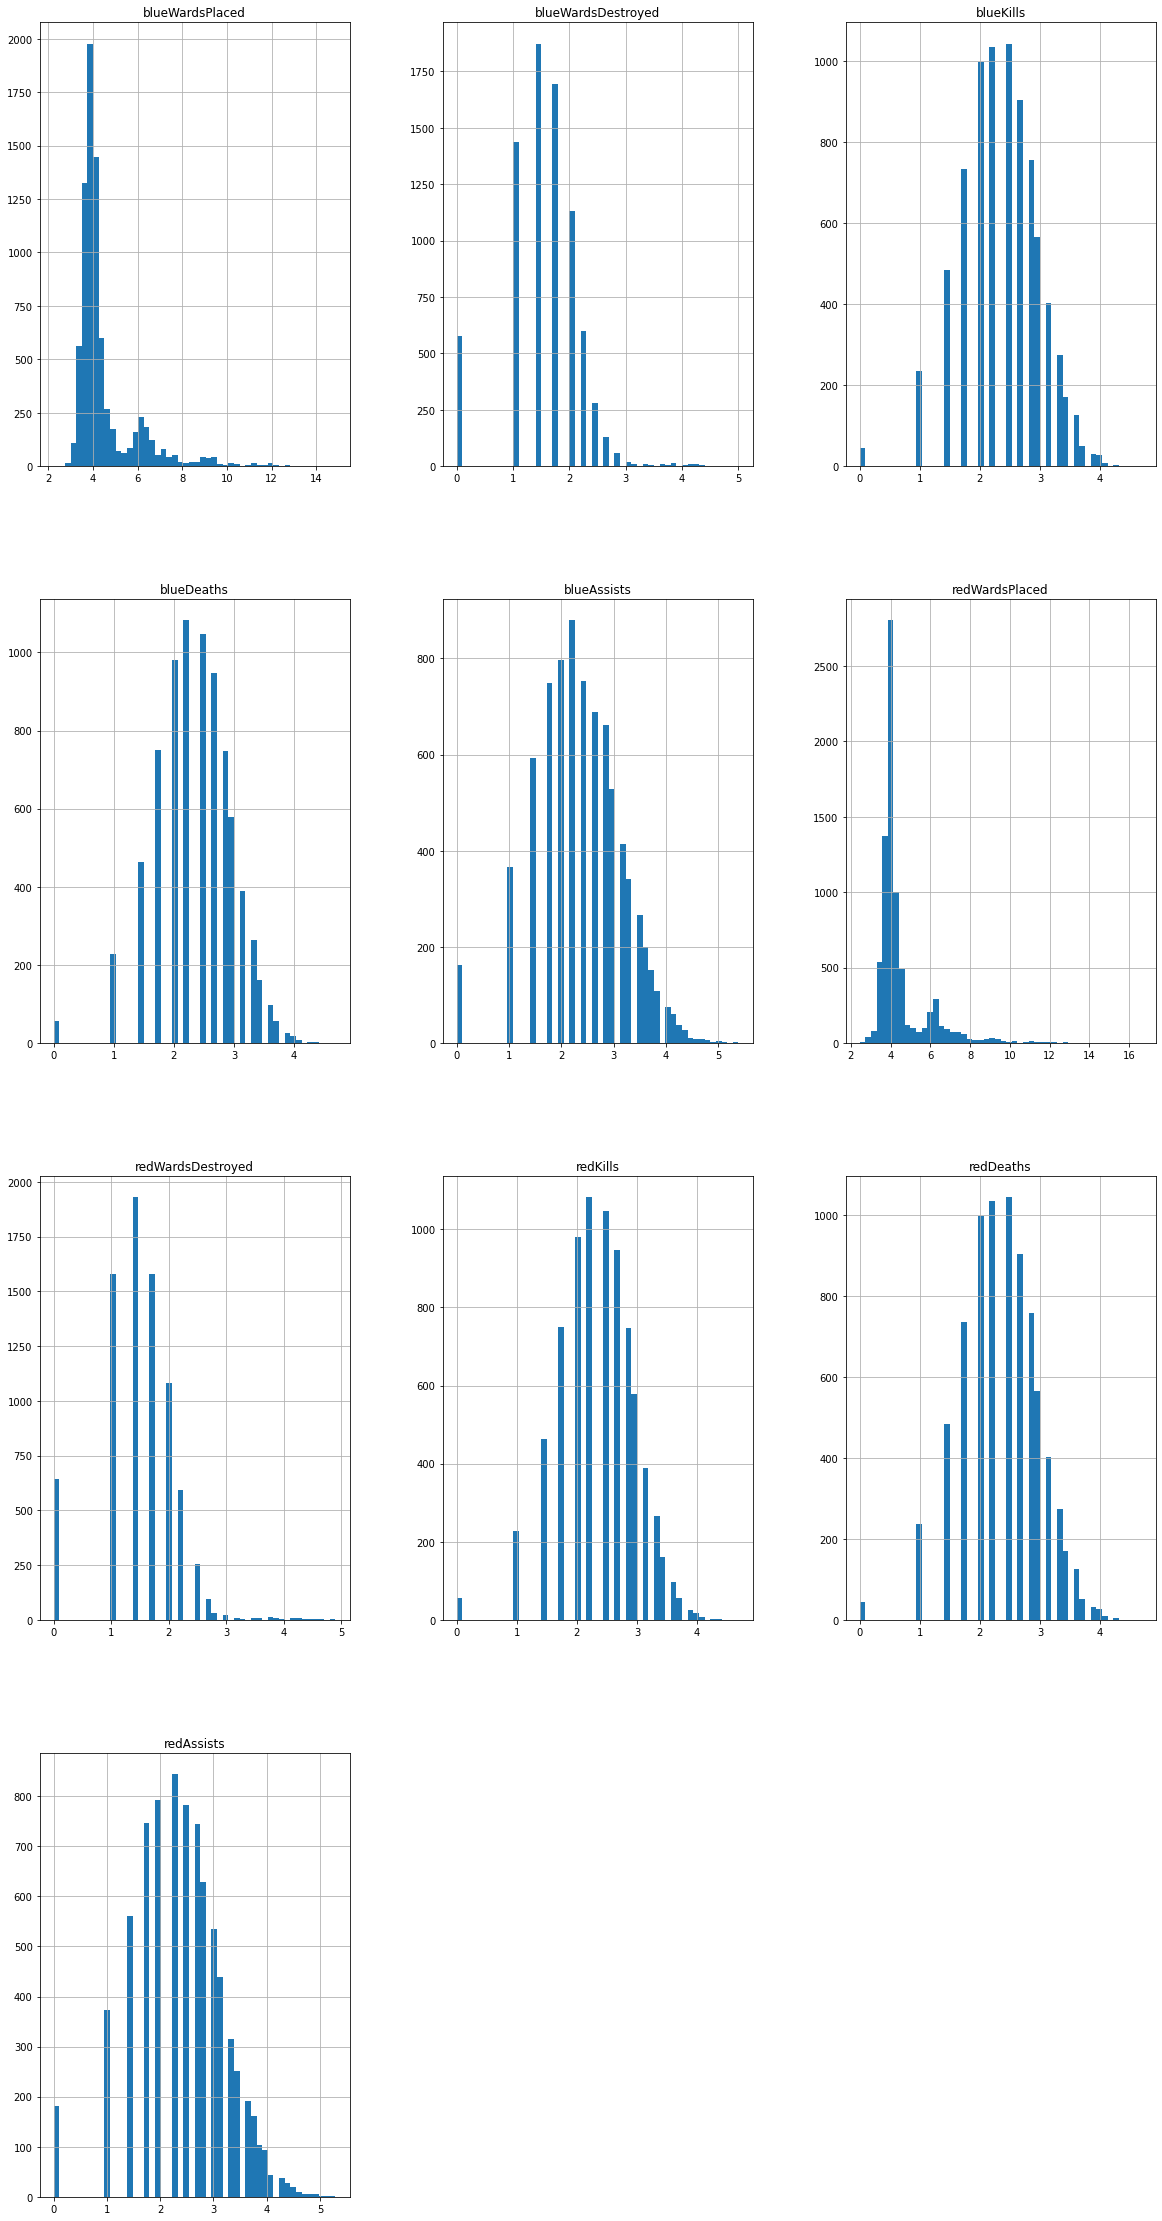

In [14]:
testClass = fix_skew(try_sqrt = True) #square-root
X_train_copy = X_train.copy()
X_train_sqrt = testClass.transform(X_train_copy)

print("Histograms after fixing the skew using a Square Root transformation.")
X_train_sqrt[cols].hist(bins = 50, figsize = (20,40))
plt.show()

In [15]:
cols1, skews1 = find_high_skew(X_train_log)
cols2, skews2 = find_high_skew(X_train_sqrt)

print("Leftover high skew after log transformation")
print(cols1, skews1)

print("==========================\n")
print("Leftover high skew after square root transformation")
print(cols2, skews2)

Leftover high skew after log transformation
['blueWardsPlaced', 'redWardsPlaced'] [2.6694835819346747, 2.826524869554289]

Leftover high skew after square root transformation
['blueWardsPlaced', 'redWardsPlaced'] [2.6694835819346747, 2.826524869554289]


It appears that both tranformations worked equally well!

### Removing Highly Correlated Features

Next, I would like to remove columns that are highly correlated. 

In [16]:
def remove_corr(X, corrTol = 0.75):
    colToDrop = set()
    for col in X.columns:
        corr = X.corr()
        corrDict = corr[col].to_dict()
        del(corrDict[col])
    for key in corrDict:
        if abs(corrDict[key]) > corrTol:
            colToDrop.add(key)
    colToDrop = list(colToDrop)
    X.drop(colToDrop, axis = 1, inplace = True)
    X.drop('gameId', axis = 1, inplace = True) # gameId does not contribute, so we remove it here.
    return X

X_train_copy = X_train.copy()

X_train_tr = remove_corr(X_train_copy)
print(X_train_tr.columns)

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueExperienceDiff', 'blueCSPerMin',
       'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redDeaths', 'redAssists', 'redEliteMonsters',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redAvgLevel',
       'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redExperienceDiff', 'redCSPerMin',
       'redGoldPerMin'],
      dtype='object')


Now we create a custom class.

In [17]:
class removeCorr(BaseEstimator, TransformerMixin):
    def __init__(self,corrTol = 0.75):
        self.corrTol = corrTol
    def fit(self, X):
        return self
    def transform(self, X):
        return remove_corr(X, self.corrTol)

## Create a Pipeline

Now, we will add all the classes into a pipeline. The final step in the pipeline will be to scale the data using sklearn's StandardScaler. First, we want the StandardScaler to return a dataframe. So I will create a class that will do that.

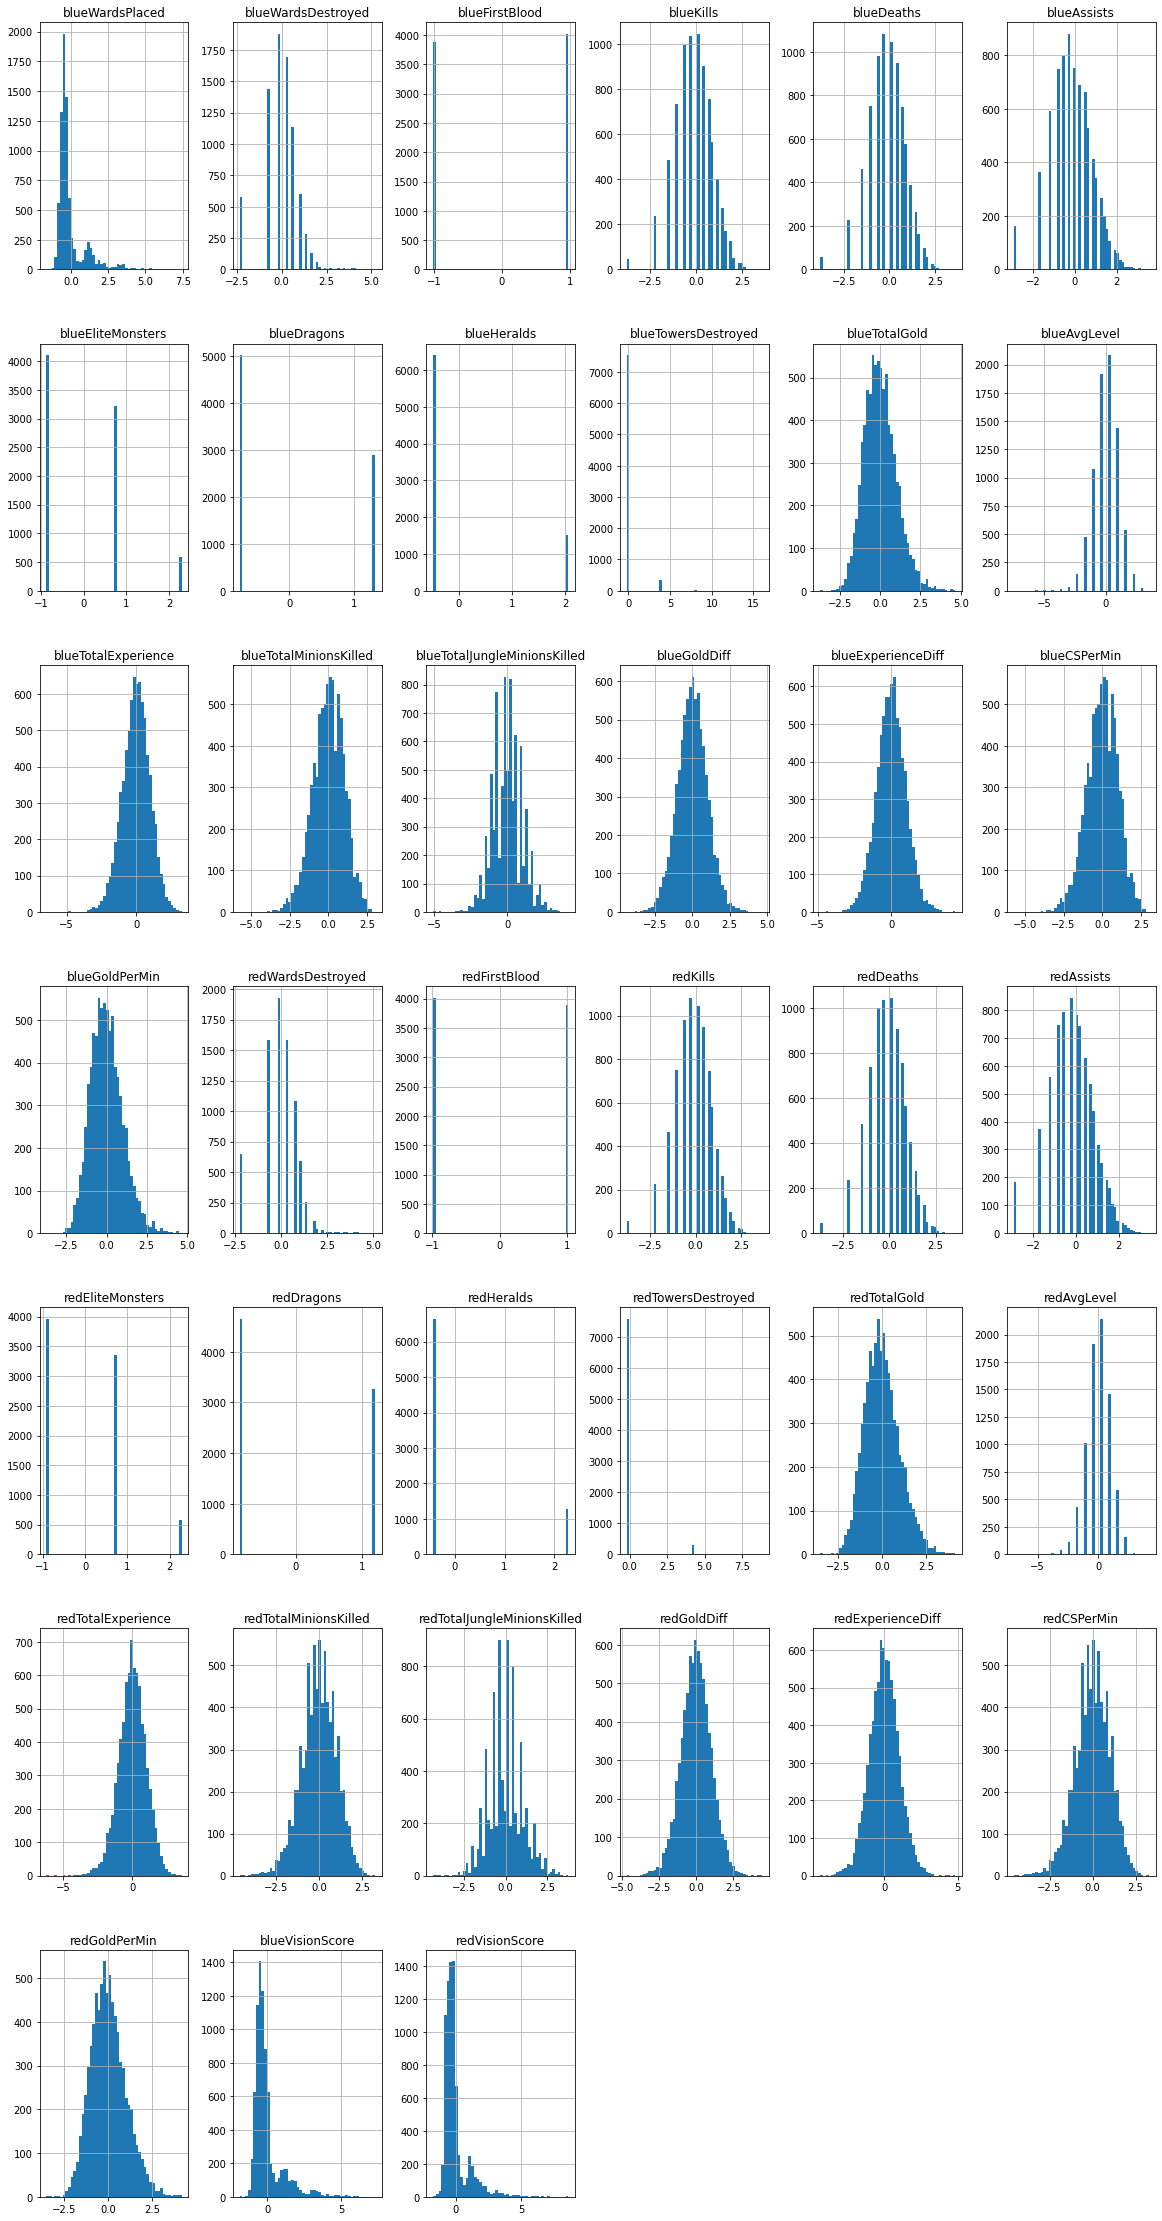

In [18]:
class scaleData(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self,X):
        tmp = X.copy()
        X = StandardScaler().fit_transform(X)
        return pd.DataFrame(X, index = tmp.index, columns = tmp.columns)

myPipe = Pipeline([
    ('attributes_adder', attributes_adder()),
    ('fix_skew', fix_skew()),
    ('removeCorr',removeCorr(corrTol = 0.95)),
    ('scaler', scaleData())
])

X_train_copy = X_train.copy()
X_train_tr = myPipe.fit_transform(X_train_copy)

X_train_tr.hist(bins = 50, figsize = (20,40))
plt.show()

# Model Building

Now it is time to train models! I will first use LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, and GradientBoostingClassifier with default parameters. Then, I will chose the most accurate model and use RandomizedSearchCV to try to improve the accuracy further.

In [19]:
def trainModel(models, X, y):
    modelScores = {}
    for model in models:
        scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = 10)
        avgScore = scores.mean()
        modelScores[model] = avgScore
    return modelScores

models = [LogisticRegression(random_state = 1), 
          DecisionTreeClassifier(random_state = 2),
          RandomForestClassifier(random_state = 3),
          GradientBoostingClassifier(random_state = 4)
         ]

modelScores = trainModel(models, X_train_tr, y_train)

for model in modelScores:
    print(model, modelScores[model])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.7303552625262046
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best') 0.6312781449535118
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
  

### Optimizing Best Model

LogisticRegression is the best model without any hyperparameter tuning. Now we will use RandomizedGridSearch to find the optimal parameters.

In [20]:
param_distributions = [{
    'C': uniform(0.01,2),
    'max_iter': [val*10 for val in range(5,16)],
    'n_jobs' : [val*10 for val in range(9,20)],
    'l1_ratio': truncnorm(a = 0, b = 1, loc = 0.5, scale = 0.1),
    'intercept_scaling': truncnorm(a = 0, b = 2, loc = 1, scale = 0.5)
}]

LR = LogisticRegression(random_state = 1)
grid_LR = RandomizedSearchCV(LR, param_distributions, cv = 10, scoring = 'accuracy', n_iter = 20)
model = grid_LR.fit(X_train_tr, y_train)
print(model.best_score_)
print(model.best_params_)
preds = model.predict(X_train_tr)

0.7303555825825346
{'C': 0.3165224900919119, 'intercept_scaling': 1.3928003847988535, 'l1_ratio': 0.505240512351702, 'max_iter': 150, 'n_jobs': 160}


Using RandomizedSearchCV, we increased our accuracy by a small amount.
Next, we predict using our fitted model and assess the accuracy using a confusion matrix.

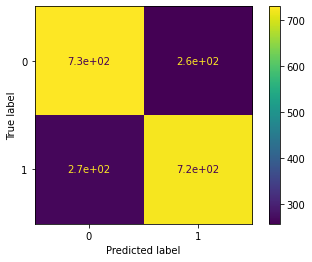

In [21]:
X_test_copy = X_test.copy()
X = myPipe.fit_transform(X_test_copy)
plot_confusion_matrix(model, X, y_test)
plt.show()

Below, we see the accuracy of the model.

In [22]:
X_test_copy = X_test.copy()
X = myPipe.fit_transform(X_test_copy)
preds = model.predict(X)
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = preds).ravel()

acc = (tn + tp)/(tn + fp + fn + tp)

print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 73.53%


# Analyzing Predictions

Next, I would like to see the characteristics of the predicted wins.

In [23]:
X = X_test.copy()
index = X.index
y = pd.Series(data = preds, index = index, name = 'blueWins')
data = pd.concat([X,y], axis = 1)
blueWins = data[data['blueWins'] == 1]
blueLoses = data[data['blueWins'] == 0]

# I only want to keep the blue attributes, so I'll drop red columns, gameId, and the 'blueWins' column
delCols = []
for col in blueWins.columns:
    if 'red' in col:
        delCols.append(col)
delCols += ['blueWins','gameId']

blueWins.drop(delCols, axis = 1, inplace = True)
blueLoses.drop(delCols, axis = 1, inplace = True)

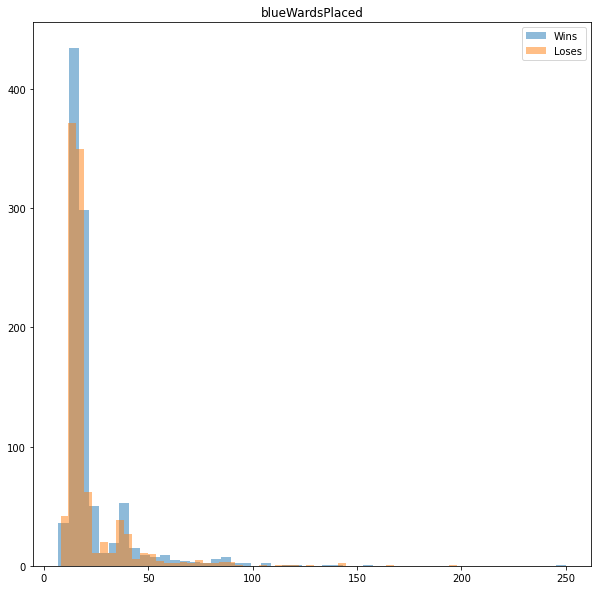

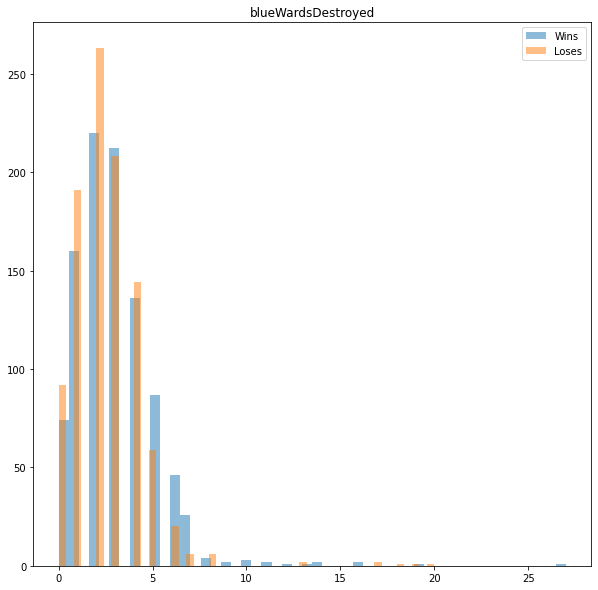

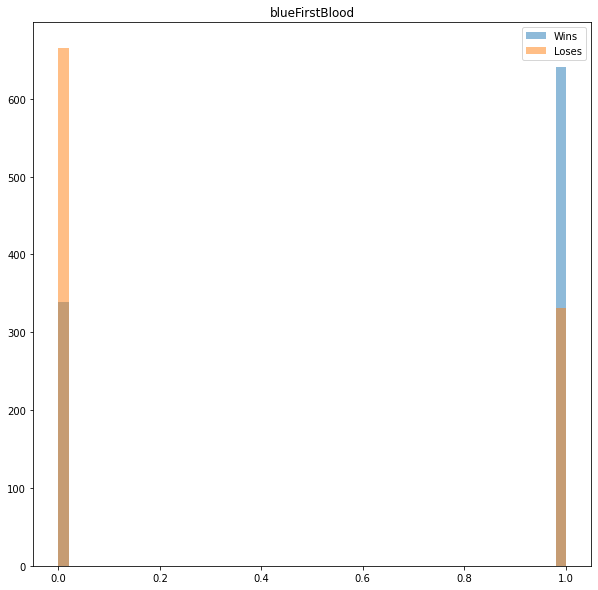

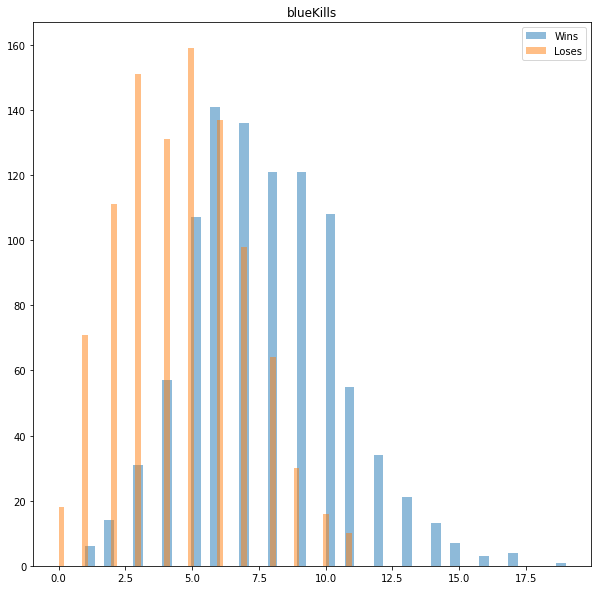

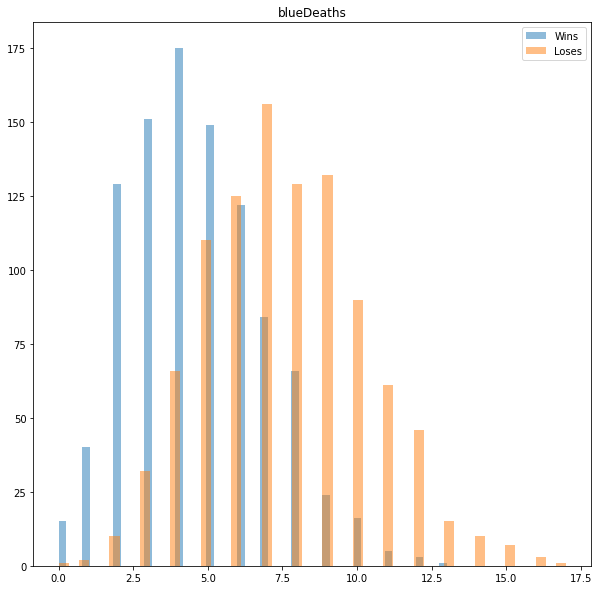

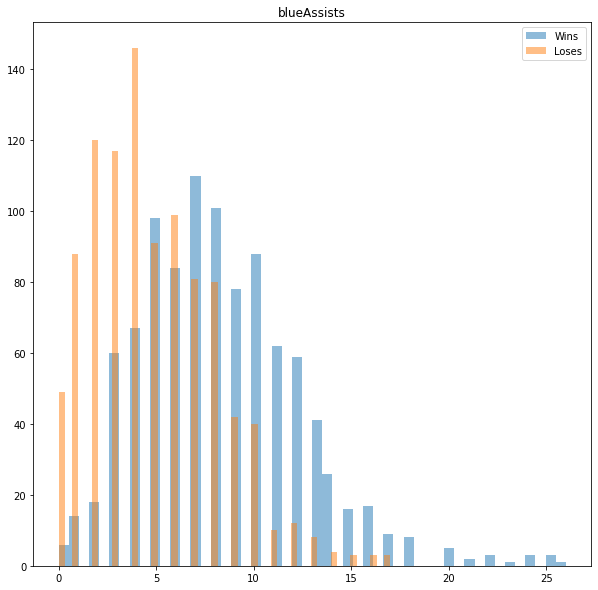

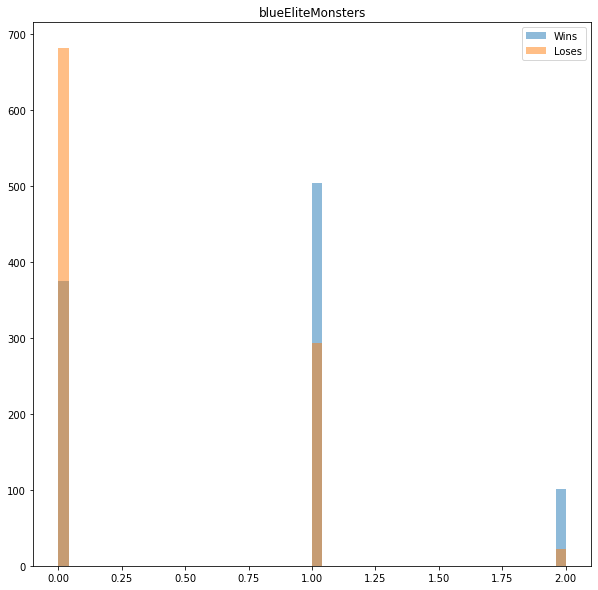

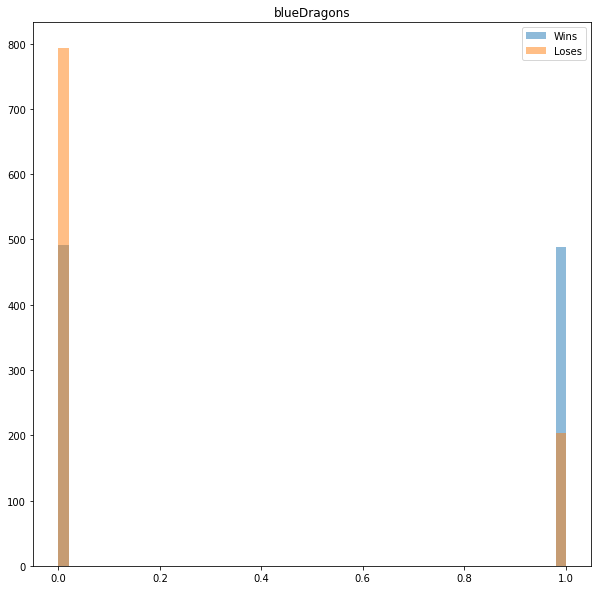

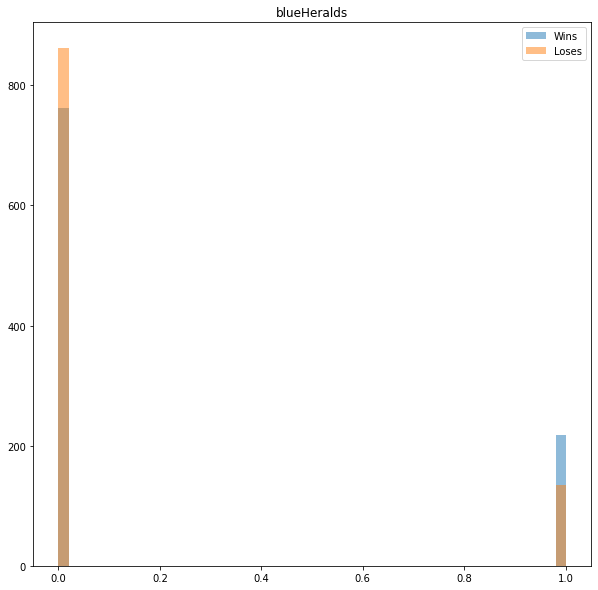

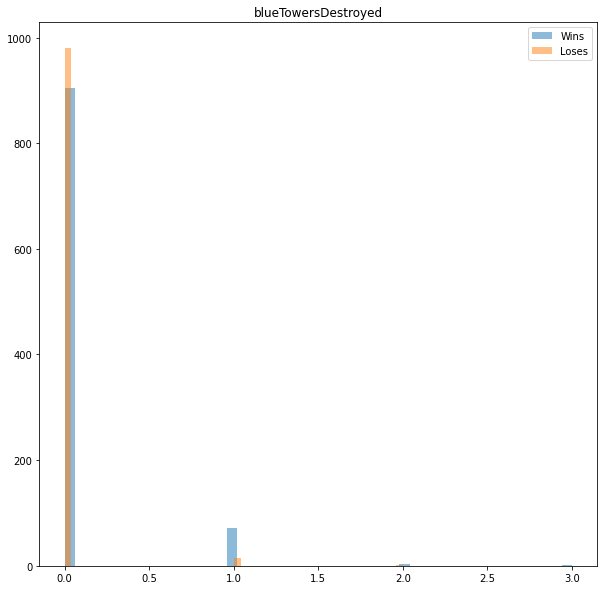

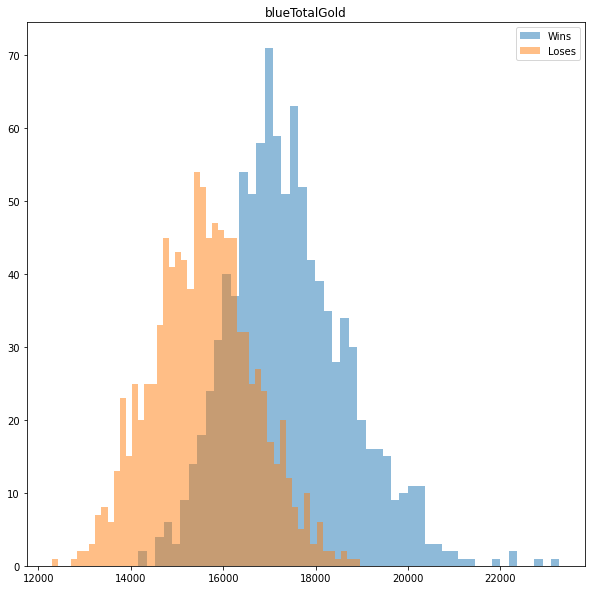

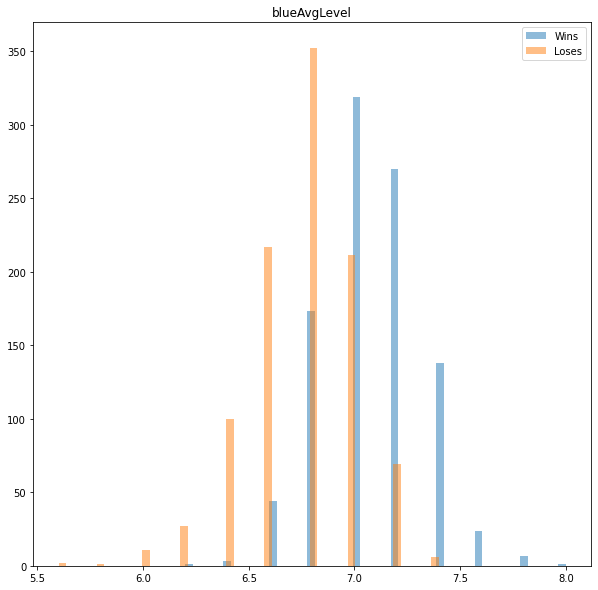

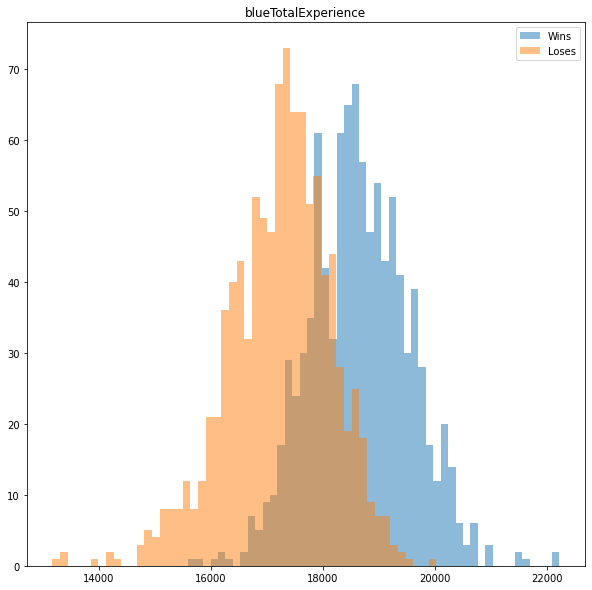

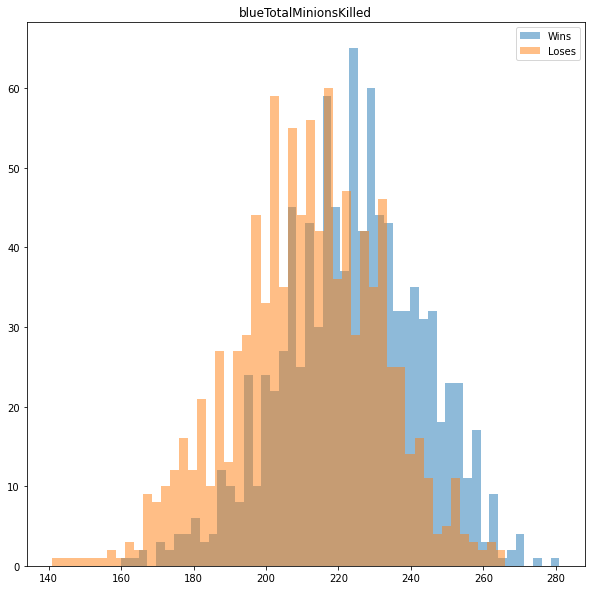

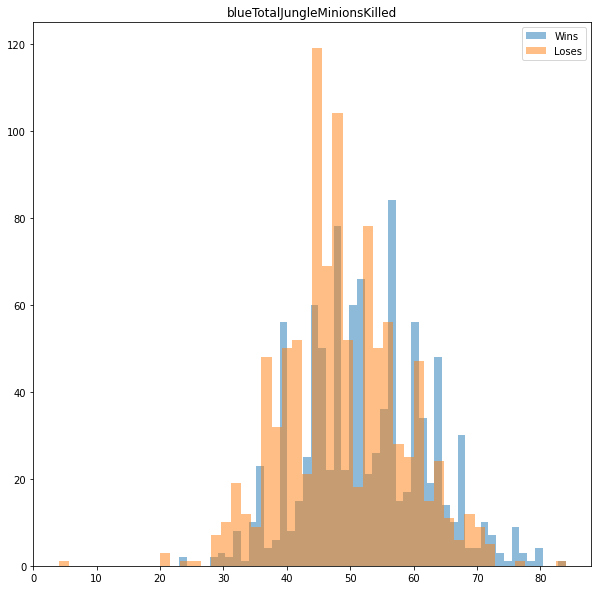

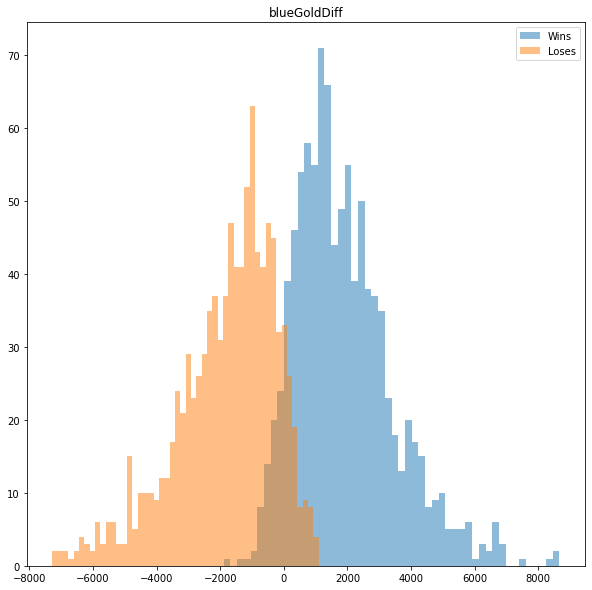

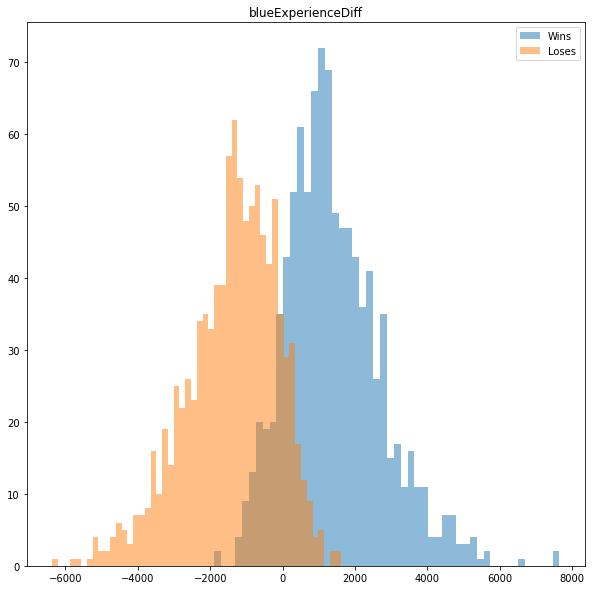

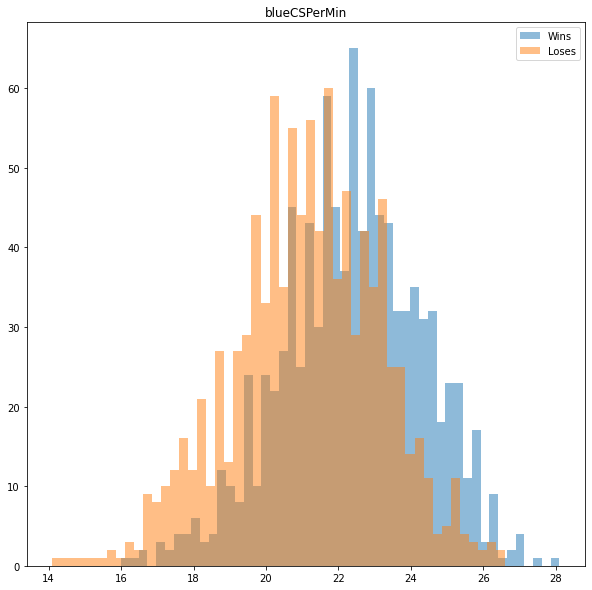

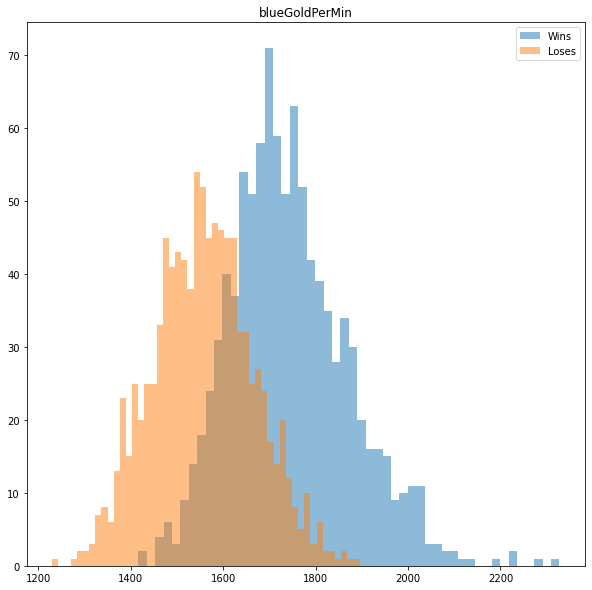

In [24]:
for col in blueWins.columns:
    fig, ax = plt.subplots(figsize = (10,10))
    plt.hist(blueWins[col], bins = 50, label = 'Wins', alpha = 0.5)
    plt.hist(blueLoses[col], bins = 50, label = 'Loses', alpha = 0.5)
    plt.title(col)
    plt.legend(loc = 'upper right')
    plt.show()

From the histograms above, we see a few key characteristics between wins and loses:

* First blood leads to a win half of the time.
* The team with the most kills is more likely to win.
* The team with the lease deaths is more likely to win.
* The team with the most assists is more likely to win. (League of Legends is a team sport!)
* The team the most elite monster kills is more likely to win.
* The team with the most dragon kills is more likely to win.
* The team that gets the rift herald is more likely to win.
* The team with more gold is most likely to win.
* The team with a higher average level is more likely to win.
* The team with the higher experience is more likely to win.
* The team with the most minions kills is more likely to win.

Most of these characteristics go hand in hand. For example, if your team has more minion kills, your team probably has higher experience level because minion kills give experience. 

# Conclusion

This data reinforces what most League of Legend players believe: "Get more kills, try not to die, make sure you farm minions, and help your teammates!"

It is worth noting that players "throwing" the game is always a possibility. This means that a team has a massive lead (either many more kills or many more objectives) could "throw" the game by misplaying and giving the opposite team an advantage. During this advantage, the opposite team could end the game. With this possibility, the losing team could have more kills, more objectives, and more experience but still lose. This could explain why the best performing model only has 73% since it cannot predict a team that "throws" the game.